In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tqdm.notebook as tqdm

from aes import AES, dump_state, compare_hex
import aes

# nice size for notebook
figsize = (13,5)

# some helper to build data representations
def prepare_data(data):
    df = pd.DataFrame(data)
    cat = pd.Categorical(data, categories=range(256))

    slices = 30
    step = len(df) // slices
    data2 = []
    for sub in range(step, len(data), step):
        tmp = pd.Categorical(df[:sub][0], categories=range(256)).value_counts()
        for b,v in tmp.iteritems():
            data2.append((sub,b,v/sub))

            
    over_time = pd.DataFrame(columns=['#cipher', 'byte', 'count'], data=data2)        
    
    return df, cat, over_time

paper: https://pdfs.semanticscholar.org/d05d/74720b05090bdae58792e82c27f55de2f33a.pdf

Basic idea: persistently corrupt one SBox lookup value. This means one sbox output will never happen. 

Final step of AES:
```
y <= SBox(x)
c <= y ^ k
```

So 
```
k == c ^ y
```

If we look at one byte. 
Corrupt one SBox value, for example `SBox[0] == 0x63 => SBox_prime[0] == 0x63 ^ 0x8`. Then there will be one value for `c` which never occurs (say `tmin`), and one value for `c` that occurs twice as much (say `tmax`). If we know the original value for `y`, `SBox[0]`, (which we do in case of AES), then `k` can be found through `k == tmin ^ SBox[0]`.

In [2]:
# setup faulty sbox

original_sbox = list(aes.s_box)
faulty_sbox = list(aes.s_box)
original_sbox_byte = original_sbox[0]
faulty_sbox[0] = faulty_sbox[0] ^ 0x8
aes.s_box = faulty_sbox

Simple example to recover `k = 0x42`:

In [3]:
k = 0x42


21 occured 0 times, matching key is 42


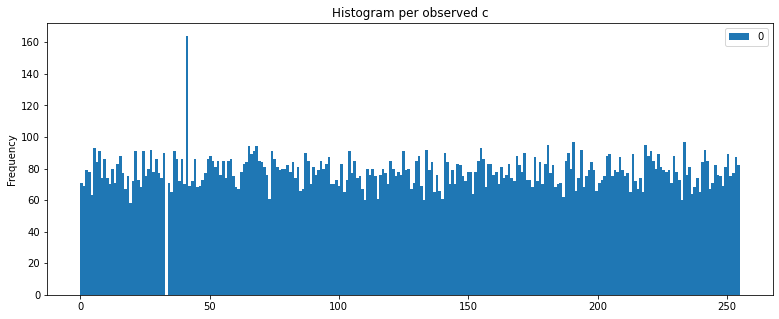

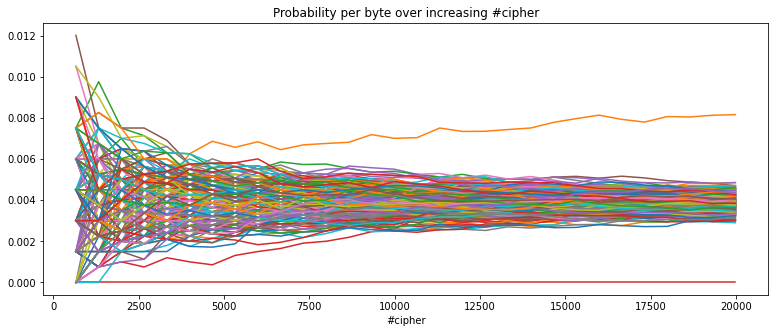

In [5]:
# generate data based on c <= SBox(x) ^ k
data = [aes.s_box[os.urandom(1)[0]] ^ k for _ in tqdm.trange(20000)]
df, cat, over_time = prepare_data(data)

# find the key byte
tmin = cat.value_counts().idxmin()
print(f'{tmin:02x} occured {cat.value_counts()[tmin]} times, matching key is {tmin ^ original_sbox_byte:02x}')

# histogram of the observed output c
ax = df.plot(kind='hist', bins=256, figsize=figsize, title='Histogram per observed c')

# plot over increasing amount of cipher texts
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Probability per byte over increasing #cipher')
for b in tqdm.tqdm(over_time['byte'].unique()):
    (over_time[over_time['byte']==b]).plot(x='#cipher', y='count', ax=ax, legend=False)

We can do the same with an actual AES. The same corrupted aes.s_box is used below.

In [6]:
# collect 10k faulty AES computations with SBox[0] == 0x63 ^ 0x8
ctx = AES(range(16))
Ncipher = int(50e3)
data2 = []
for _ in tqdm.trange(Ncipher):
    data2.append(ctx.encrypt_block(os.urandom(16)))
data2 = np.array(list(map(bytearray, data2)))

In [7]:
# prepare data per key byte index
cat_per_kbidx = []
for kbidx in tqdm.trange(16):
    df, cat, over_time = prepare_data(data2.transpose()[kbidx])
    cat_per_kbidx.append(cat)
    
    # find the key byte
    tmin = cat.value_counts().idxmin()
    print(f'{tmin:02x} occured {cat.value_counts()[tmin]} times, matching key is {tmin ^ original_sbox_byte:02x}')

70 occured 0 times, matching key is 13
72 occured 0 times, matching key is 11
7e occured 0 times, matching key is 1d
1c occured 0 times, matching key is 7f
80 occured 0 times, matching key is e3
f7 occured 0 times, matching key is 94
29 occured 0 times, matching key is 4a
74 occured 0 times, matching key is 17
90 occured 0 times, matching key is f3
64 occured 0 times, matching key is 07
c4 occured 0 times, matching key is a7
e8 occured 0 times, matching key is 8b
2e occured 0 times, matching key is 4d
48 occured 0 times, matching key is 2b
53 occured 0 times, matching key is 30
a6 occured 0 times, matching key is c5



In [8]:
# correct rk10 vs. rk10 found
rk10 = ctx._key_matrices[-1]
found = aes.bytes2matrix([cat.value_counts().idxmin() ^ original_sbox_byte for cat in cat_per_kbidx])
dump_state('correct', rk10)
dump_state('found', found)

correct
    13, e3, f3, 4d
    11, 94, 07, 2b
    1d, 4a, a7, 30
    7f, 17, 8b, c5
found
    13, e3, f3, 4d
    11, 94, 07, 2b
    1d, 4a, a7, 30
    7f, 17, 8b, c5


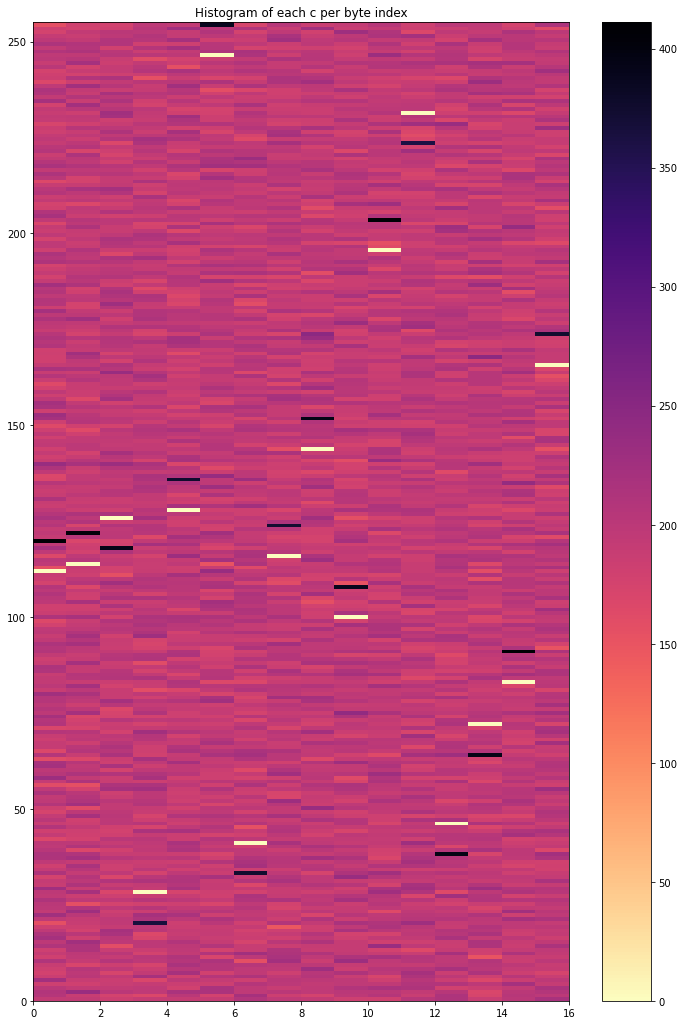

In [9]:
# a histogram of all the key bytes
# should see one white and one black line per byte index
df = pd.DataFrame(columns=['cbyte', 'kbidx'])
for kbidx in range(16):
    col = data2.transpose()[kbidx]
    tmp = np.array([col, [kbidx]*len(col)]).transpose()
    tmp = pd.DataFrame(tmp, columns=['cbyte', 'kbidx'])
    df = df.append(tmp)

fig, ax = plt.subplots()
fig.set_size_inches(12, 18)
ax.set_title('Histogram of each c per byte index')
cmap = plt.cm.magma_r
h = ax.hist2d(df['kbidx'], df['cbyte'], bins=(range(17),256), cmap=cmap, alpha=1)
fig.colorbar(h[3])

In [10]:
# "ranking" the options
for kbidx in range(16):
    cat = cat_per_kbidx[kbidx]
    print(f'top 3 values for {kbidx}:')
    print(cat.value_counts().sort_values()[:3])

top 3 values for 0:
112      0
255    156
113    156
dtype: int64
top 3 values for 1:
114      0
25     156
56     156
dtype: int64
top 3 values for 2:
126      0
111    157
14     159
dtype: int64
top 3 values for 3:
28       0
241    155
81     159
dtype: int64
top 3 values for 4:
128      0
244    156
169    163
dtype: int64
top 3 values for 5:
247      0
114    152
238    158
dtype: int64
top 3 values for 6:
41      0
45    155
10    157
dtype: int64
top 3 values for 7:
116      0
19     147
144    158
dtype: int64
top 3 values for 8:
144      0
104    156
190    160
dtype: int64
top 3 values for 9:
100      0
109    154
126    156
dtype: int64
top 3 values for 10:
196      0
198    156
197    163
dtype: int64
top 3 values for 11:
232      0
226    162
13     164
dtype: int64
top 3 values for 12:
46       0
138    163
28     165
dtype: int64
top 3 values for 13:
72       0
11     152
189    159
dtype: int64
top 3 values for 14:
83       0
185    160
147    161
dtype: int64
top 3 va

We can also look at the SEI, which in our case is obviously high, as two values are completely throwing off the uniformity.

In [11]:
# SEI formula (how close it the distribution to uniform)
uniform = np.ones(256)/256
def SEI_score(dist):
    return sum((uniform - dist) ** 2)

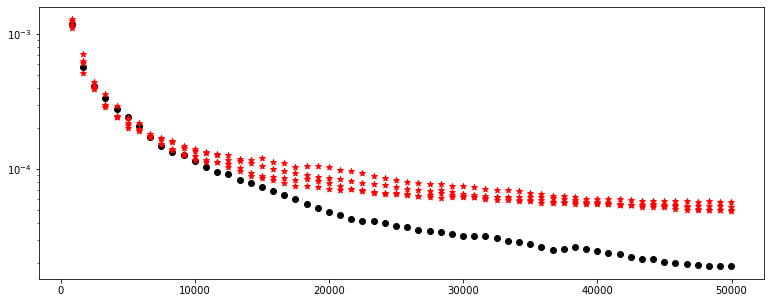

In [12]:
# some random data for reference
rand = pd.Categorical(os.urandom(Ncipher), categories=range(256))

fig, ax = plt.subplots()
fig.set_size_inches(*figsize)
slices = 60
step = len(rand) // slices
for sub in range(step, len(rand), step):
    v1 = SEI_score(rand[:sub].value_counts()/sub)
    v2 = SEI_score(cat_per_kbidx[0][:sub].value_counts()/sub)
    v3 = SEI_score(cat_per_kbidx[4][:sub].value_counts()/sub)
    v4 = SEI_score(cat_per_kbidx[8][:sub].value_counts()/sub)
    v5 = SEI_score(cat_per_kbidx[12][:sub].value_counts()/sub)
    ax.scatter(sub, v1, c='k')
    ax.scatter(sub, v2, c='r', marker='*')
    ax.scatter(sub, v3, c='r', marker='*')
    ax.scatter(sub, v4, c='r', marker='*')
    ax.scatter(sub, v5, c='r', marker='*')
ax.set_yscale('log')
    

After calculating one round back, the bias is still there when using the correct key, and gone when using incorrect key. Can use this for 32-bit key guesses.

In [13]:
# using the correct key
states = []
for d in tqdm.tqdm(data2):
    state = aes.bytes2matrix(d)
    aes.add_round_key(state, rk10)
    aes.inv_shift_rows(state)
    aes.inv_sub_bytes(state)
    aes.inv_mix_columns(state)
    states.append(aes.matrix2bytes(state))
states = np.array(list(map(bytearray, states)))

In [14]:
# using a random key
random_key = aes.bytes2matrix(os.urandom(16))
states_incorrect = []
for d in tqdm.tqdm(data2):
    state = aes.bytes2matrix(d)
    aes.add_round_key(state, random_key)
    aes.inv_shift_rows(state)
    aes.inv_sub_bytes(state)
    aes.inv_mix_columns(state)
    states_incorrect.append(aes.matrix2bytes(state))
states_incorrect = np.array(list(map(bytearray, states_incorrect)))

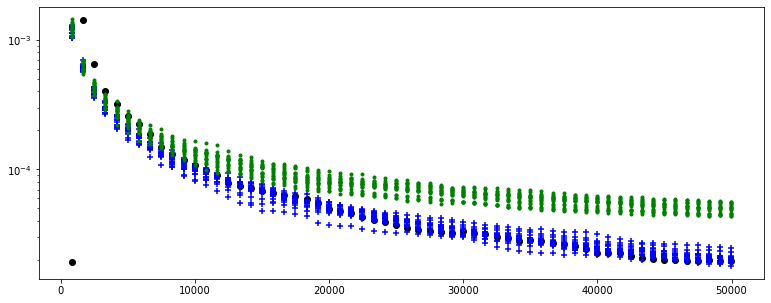

In [15]:
rand = pd.Categorical(os.urandom(Ncipher), categories=range(256))
fig, ax = plt.subplots()
fig.set_size_inches(*figsize)
slices = 60
step = len(rand) // slices
for sub in tqdm.trange(step, len(rand), step):
    ax.scatter(sub, v1, c='k')
    for kbidx in range(16):
        col = states_incorrect.transpose()[kbidx]
        cat = pd.Categorical(col, categories=range(256))
        cat.value_counts().sort_values()
        v4 = SEI_score(cat[:sub].value_counts()/sub)
        ax.scatter(sub, v4, c='b', marker='+')
    for kbidx in range(16):
        col = states.transpose()[kbidx]
        cat = pd.Categorical(col, categories=range(256))
        cat.value_counts().sort_values()
        v3 = SEI_score(cat[:sub].value_counts()/sub)
        ax.scatter(sub, v3, c='g', marker='.', label='random')
    v1 = SEI_score(rand[:sub].value_counts()/sub)
ax.set_yscale('log')